## Project ECG - step 1
Read project_ecg_step_1.pdf and 1D_Signal_Processing_Peak_Detection.ipynb

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.ndimage

Load the ECG data from ecg_data1.csv using pandas <br>
The ipynb file and the data file ecg_data1.csv should be in the same file folder  <br>
the ECG signal should be stored in a numpy array  <br>
the Sampling Rate is known to be 1000Hz  <br>

In [18]:
# load data from ecg_data1.csv using pandas
# Get the 'Amp' volume and convert it to a numpy array x
data = pd.read_csv('ecg_data_step1.csv')
data.head()

,Amp
0,2044.0
1,2044.0
2,2044.0
3,2044.0
4,2044.0


In [19]:
#check missing values
data.isnull().sum()

Amp    0
dtype: int64

In [20]:
#get the signal and convert it to numpy array
x = data['Amp'].values
type(x)

numpy.ndarray

In [21]:
#some parameters of the signal
fs = 1000 # sampling rate (Hz)
Ts = 1/fs # sampling intervel (seconds)
N = x.shape[0] # total number of data points in the ECG signal x
Duration= N/fs #seconds

Visualize the ECG signal x

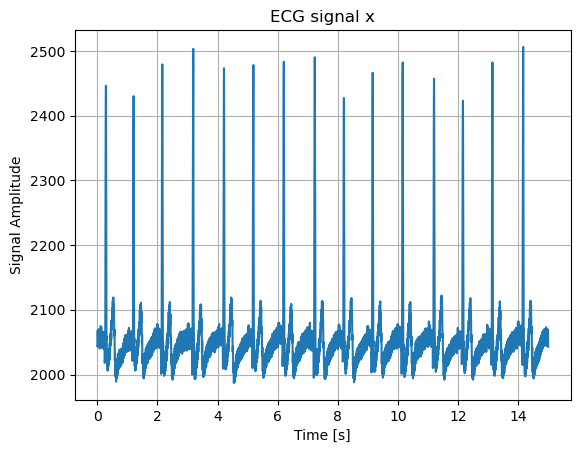

In [22]:
t = np.linspace(0, Duration-Ts, N)
fig, ax = plt.subplots()
ax.plot(t, x, '-')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal Amplitude')
ax.set_title('ECG signal x')
ax.grid(True)


Build a GaussianKernel for smoothing the ECG signal x <br>

(-0.011, 0.011)

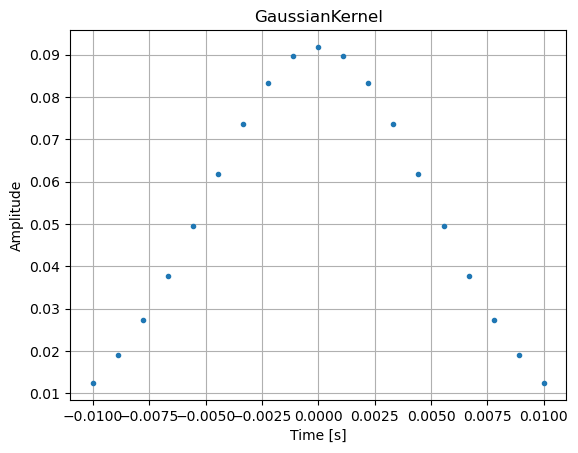

In [23]:
#use linspace to make an array of length 19 from -0.01 to 0.01
tg = np.linspace(-0.01, 0.01, 19, endpoint=True) 
sigma=0.005
GaussianKernel = np.exp(-tg**2/(2*sigma**2))
GaussianKernel/=GaussianKernel.sum()
#plot the kernel
fig, ax = plt.subplots()
ax.plot(tg, GaussianKernel, '.')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.grid(True)
ax.set_title('GaussianKernel')
ax.set_xlim([-0.0110, 0.0110])


Smooth the ECG signal `x` using cross-correlation (correlate) with GaussianKernel <br>
Name the smoothed signal `x_smoothed` <br>
Visualize the smoothed signal `x_smoothed` and the original signal `x` in a figure

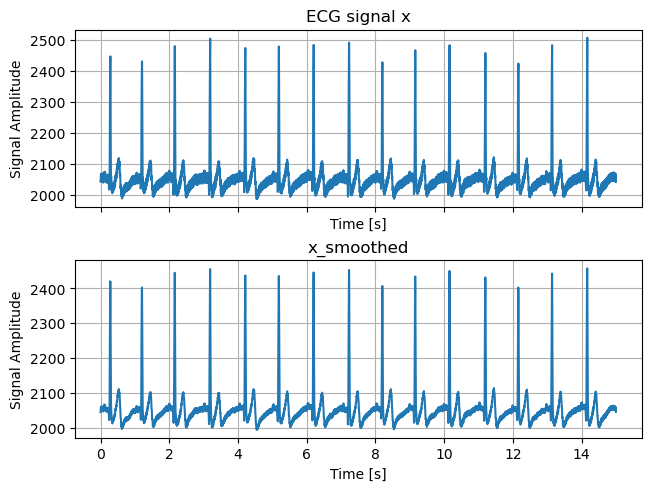

In [24]:
from scipy.ndimage import correlate
x_smoothed = correlate(x, GaussianKernel, mode='nearest')
fig, ax = plt.subplots(2, 1, sharex=True, constrained_layout=True)
ax[0].plot(t, x, '-')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Signal Amplitude')
ax[0].set_title('ECG signal x')
ax[0].grid(True)
ax[1].plot(t, x_smoothed, '-')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Signal Amplitude')
ax[1].set_title('x_smoothed')
ax[1].grid(True)

Perform peak detection on x_smoothed, using two kernels: h1 and h2 <br>

In [25]:
#create a peak_detector function
def peak_detector(x):
    #two kernels
    h1 = [-1, 1, 0]
    h2 = [0, 1, -1]
    y = correlate(x, h1, mode='nearest')
    z = correlate(x, h2, mode='nearest')
    #find the indexes of the positive elements in y
    IndexArray1= np.where(y>0) 
    #find the indexes of the positive elements in z
    IndexArray2= np.where(z>0) 
    # find the intersection of IndexArray1 and IndexArray2
    PeakIndexArray = np.intersect1d(IndexArray1, IndexArray2) 
    # a better way to get PeakIndexArray
    #PeakIndexArray = np.where((y>0)&(z>0))[0]
    return PeakIndexArray
peak_idx_array = peak_detector(x_smoothed)
peak_idx_array.shape

(691,)

Visualize the ECG signal `x` and the peaks detected from x_smoothed (no need to plot x_smoothed)

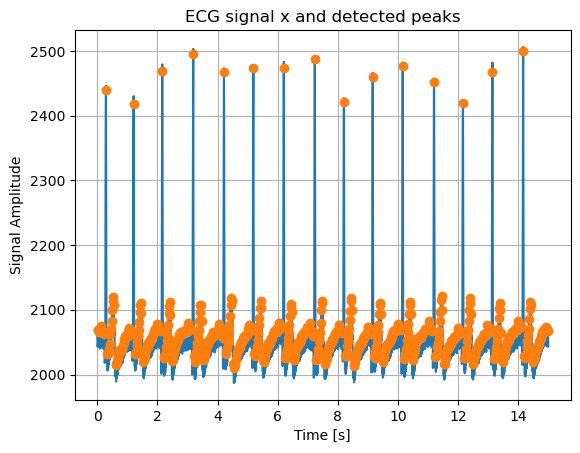

In [26]:
fig, ax = plt.subplots()
ax.plot(t, x, '-')
ax.plot(t[peak_idx_array], x[peak_idx_array], 'o')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal Amplitude')
ax.set_title('ECG signal x and detected peaks')
ax.grid(True)

We need to find the R-peaks from the detected peaks<br>
Select the peaks with amplitude values > threshold <br>
It is NOT acceptable to simply set threshold to a manually defined number (e.g.,  threshold=2000)

In [27]:
sD = np.std(x_smoothed[peak_idx_array])
mean = np.mean(x_smoothed[peak_idx_array])
threshold = sD * 2 + mean
RPeakIndexArray = [y for y in peak_idx_array if x[y] > threshold]
#len(true_peaks)

Visualize the R-peaks and the signal `x`

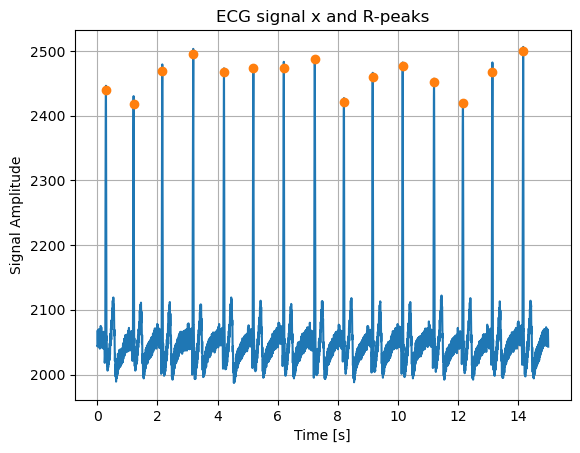

In [28]:
fig, ax = plt.subplots()
ax.plot(t, x, '-')
ax.plot(t[RPeakIndexArray], x[RPeakIndexArray], 'o')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal Amplitude')
ax.set_title('ECG signal x and R-peaks')
ax.grid(True)


Calculate heart rate per minute based on the R-peaks and visualize the result

[  284  1204  2159  3189  4211  5189  6201  7232  8200  9158 10156 11198
 12160 13140 14164]


(0.0, 100.0)

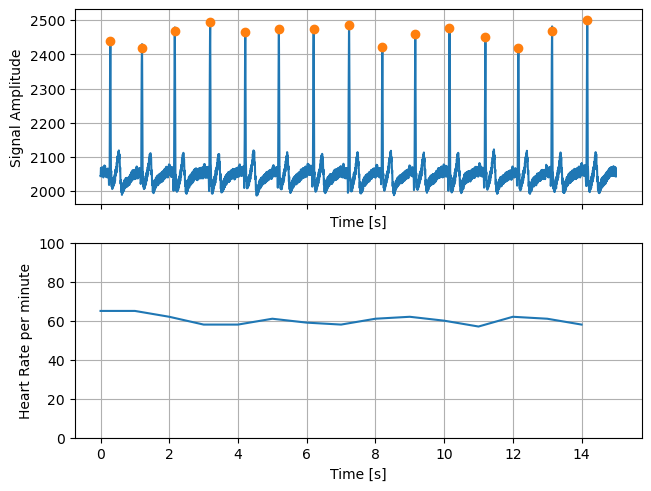

In [29]:
RPeakIndexArray = np.array(RPeakIndexArray)
HeartRate = np.zeros_like(RPeakIndexArray)
print(RPeakIndexArray)
for n in range(1, RPeakIndexArray.shape[0]):
    HeartRate[n]=60*fs/(RPeakIndexArray[n]-RPeakIndexArray[n-1])
HeartRate[0] = HeartRate[1]
fig, ax = plt.subplots(2, 1, sharex=True, constrained_layout=True)
ax[0].plot(t, x, '-')
ax[0].plot(t[RPeakIndexArray], x[RPeakIndexArray], 'o')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Signal Amplitude')
ax[0].grid(True)
ax[1].plot(HeartRate, '-')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Heart Rate per minute')
ax[1].grid(True)
ax[1].set_ylim([0, 100])